In [1]:
import torch.utils.data as utils
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import math
import numpy as np
import pandas as pd
import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt

In [4]:
import importlib

In [5]:
import utils

In [6]:
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

torch.cuda.set_device(0)

np.random.seed(1024)

In [7]:
speed_matrix = pd.read_hdf('../Data/PEMS-BAY/pems-bay.h5')

In [8]:
A = pd.read_pickle('../Data/PEMS-BAY/adj_mx_bay.pkl')
A = A[2]
A[np.where(A != 0)] = 1
for i in range(0, A.shape[0]):
    A[i,i] = 1
    for j in range(i, A.shape[0]):
        if A[i,j] == 1:
            A[j,i] = 1
A.shape

(325, 325)

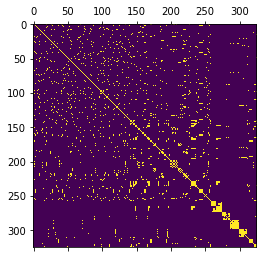

In [9]:
A = pd.read_pickle('../Data/PEMS-BAY/adj_mx_bay.pkl')
A = A[2]
A[np.where(A != 0)] = 1
for i in range(0, A.shape[0]):
    A[i,i] = 1
    for j in range(0, A.shape[0]):
        if A[i,j] == 1:
            A[j,i] = 1
plt.matshow(A)

In [10]:
importlib.reload(utils)
from utils import PrepareDataset
train_dataloader, valid_dataloader, test_dataloader, max_speed, X_mean = PrepareDataset(speed_matrix, BATCH_SIZE = 64, random_seed = 1)

Start Generate Data
	 batch_size: 64 		 input_len: 10 			 pred_len: 1
	 train_set: 0.7 		 valid_set: 0.2 		 test_set: 0.1
	 masking: True 			 mask_ones_rate: 0.8 		 delta & last_obsv: False
	 shuffle dataset: True 		 random_seed: 1
Orignal dataset missing rate: 3.075978438630983e-05
Generating input and labels...
	 Masked dataset missing rate: 0.2001 (mask zero rate: 0.2 )
Input sequences, labels, and masks are generated.
Start to shuffle dataset ...
Dataset Shuffled. Start to split dataset ...
Finished


In [11]:
max_speed

85.1

In [12]:
inputs, labels = next(iter(train_dataloader))
[batch_size, type_size, step_size, fea_size] = inputs.size()

In [13]:
importlib.reload(utils)
from utils import TrainModel, TestModel

In [14]:
n = A.shape[0]
num_layer = 6

In [15]:
class GMN(nn.Module):
    def __init__(self, A, dtype, device, num_layer = 5, gamma = 0.9):
        super(GMN, self).__init__()
        self.gamma = gamma
        self.n = A.shape[0]
        self.num_layer = num_layer
        self.dtype = dtype
        self.device = device
        
        self.A = torch.tensor(A, dtype = self.dtype, device = self.device)
        self.A = torch.clamp(self.A, min=0, max=1)
        
        self.A_list = torch.empty(self.num_layer, self.n, self.n, dtype = self.dtype, device = self.device)
        for i in range(self.num_layer):
            if i == 0:
                self.A_list[i] = self.A
            else:
                self.A_list[i] = torch.clamp(torch.matmul(self.A_list[i-1], self.A), min=0, max=1)


        W_list = torch.empty(self.num_layer, self.n, self.n, dtype = self.dtype, device = self.device)
        nn.init.uniform_(W_list)
        self.W_list = torch.nn.Parameter(W_list)
        
        
    def forward(self, input):
        batch_size = input.size(0)
        type_size = input.size(1)
        step_size = input.size(2)
        spatial_size = input.size(3)

        X = torch.squeeze(input[:,0,:,:])
        M = torch.squeeze(input[:,1,:,:])
        
        Y_hat = None
        for i in range(0, self.num_layer):
            if i == 0:
                Y_hat = self.gamma * (torch.mm(X[:,-1,:], self.A_list[0] * self.W_list[0]))
            elif i == 1:
                Y_hat += self.gamma**2 * (torch.mm(X[:,-2,:] * (1-M[:,-1,:]), self.A_list[1] * self.W_list[1]))
            else: # i >= 2
                NonMissing = (1-M[:,-1,:])
                for j in range(1, i):
                    NonMissing = NonMissing * (1-M[:,-(j+1),:])
                Y_hat += self.gamma**(i+1) * (torch.mm(X[:,-(i+1),:] * NonMissing, self.A_list[i] * self.W_list[i]))
        
        return Y_hat
        

In [16]:
class SGMN(nn.Module):
    def __init__(self, A, dtype, device, num_layer = 6, gamma = 0.9):
        
        super(SGMN, self).__init__()
        
        self.gamma = gamma
        self.num_layer = num_layer
        self.dtype = dtype
        self.device = device
        
        self.n = A.shape[0]
        A = torch.tensor(A, dtype = self.dtype, device = self.device)
        D_rsqrt = torch.tensor(torch.diag(torch.sum(A, dim=0).pow(-0.5)), dtype = self.dtype, device = self.device)
        I = torch.tensor(torch.eye(self.n, self.n), dtype = self.dtype, device = self.device)
        self.L = I - D_rsqrt.mm(A).mm(D_rsqrt)
        self.e, self.v = torch.symeig(self.L, eigenvectors=True)
        
        
        self.Lambda_list = torch.empty(self.num_layer, self.n, dtype = self.dtype, device = self.device)
        
        for i in range(self.num_layer):
            self.Lambda_list[i] = torch.Tensor(self.n)
            nn.init.uniform_(self.Lambda_list[i])
            
        self.Lambda_list = Parameter(self.Lambda_list)
                
        
    def forward(self, input):
        
        batch_size = input.size(0)
        type_size = input.size(1)
        step_size = input.size(2)
        spatial_size = input.size(3)

        X = torch.squeeze(input[:,0,:,:])
        M = torch.squeeze(input[:,1,:,:])
        
        Y_hat = None
        for i in range(0, self.num_layer):
            if i == 0:
                Y_hat = self.gamma * (torch.mm(X[:,-1,:], self.v.matmul(torch.diag(self.Lambda_list[0])).matmul(torch.t(self.v))))
            elif i == 1:
                Y_hat += self.gamma**2 * (torch.mm(X[:,-2,:] * (1-M[:,-1,:]), self.v.matmul(torch.diag(self.Lambda_list[1])).matmul(torch.t(self.v))))
            else:
                # i >= 2
                NonMissing = (1-M[:,-1,:])
                for j in range(1, i):
                    NonMissing = NonMissing * (1-M[:,-(j+1),:])
                Y_hat += self.gamma**(i+1) * (torch.mm(X[:,-(i+1),:] * NonMissing, self.v.matmul(torch.diag(self.Lambda_list[i])).matmul(torch.t(self.v))))
        
        return Y_hat


Epoch: 0, train_loss: 12.79031536, valid_loss: 1.69262837, lr: 0.001, train_time: [4.45], valid_time: [0.88], best model: 1
Epoch: 1, train_loss: 0.58690867, valid_loss: 0.26805111, lr: 0.001, train_time: [4.46], valid_time: [0.93], best model: 1
Epoch: 2, train_loss: 0.22792194, valid_loss: 0.19251325, lr: 0.001, train_time: [4.6], valid_time: [0.93], best model: 1
Epoch: 3, train_loss: 0.16100786, valid_loss: 0.13194274, lr: 0.001, train_time: [4.49], valid_time: [0.87], best model: 1
Epoch: 4, train_loss: 0.10679747, valid_loss: 0.08506936, lr: 0.001, train_time: [4.29], valid_time: [0.81], best model: 1
Epoch: 5, train_loss: 0.06694348, valid_loss: 0.05228806, lr: 0.001, train_time: [4.37], valid_time: [0.81], best model: 1
Epoch: 6, train_loss: 0.04040608, valid_loss: 0.03144845, lr: 0.001, train_time: [4.15], valid_time: [0.81], best model: 1
Epoch: 7, train_loss: 0.02428032, valid_loss: 0.01926723, lr: 0.001, train_time: [4.12], valid_time: [0.81], best model: 1
Epoch: 8, train_

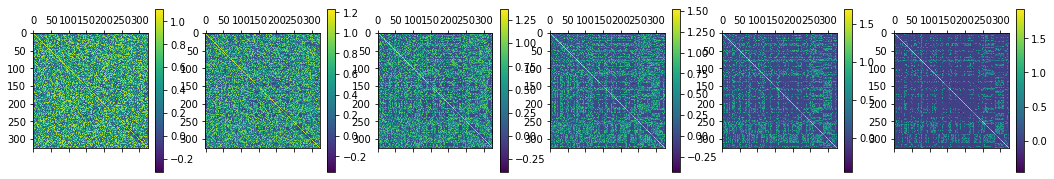

In [17]:
num_layer = 6
gmn = GMN(A, num_layer = num_layer, gamma = 0.9, dtype = dtype, device = device)
gmn, gmn_loss = TrainModel(gmn, train_dataloader, valid_dataloader, learning_rate = 1e-3, patience = 5)
gmn_test = TestModel(gmn, test_dataloader, max_speed)

# Plot weights
n = num_layer
fig, axs = plt.subplots(1, n, figsize=(n*3, 3))
for i in range(n):
    img = axs[i].matshow(gmn.W_list[i].data.cpu().numpy())
    fig.colorbar(img, ax=axs[i])

In [18]:
num_layer = 6
sgmn = SGMN(A, num_layer = num_layer, gamma = 0.9, dtype = dtype, device = device)
sgmn, sgmn_loss = TrainModel(sgmn, train_dataloader, valid_dataloader, learning_rate = 1e-3, patience = 5)
sgmn_test = TestModel(sgmn, test_dataloader, max_speed)

Epoch: 0, train_loss: 0.01626273, valid_loss: 0.00536946, lr: 0.001, train_time: [4.8], valid_time: [0.9], best model: 1
Epoch: 1, train_loss: 0.00341136, valid_loss: 0.00208368, lr: 0.001, train_time: [4.9], valid_time: [0.9], best model: 1
Epoch: 2, train_loss: 0.00157039, valid_loss: 0.00116736, lr: 0.001, train_time: [4.85], valid_time: [0.91], best model: 1
Epoch: 3, train_loss: 0.00103513, valid_loss: 0.00087244, lr: 0.001, train_time: [4.86], valid_time: [0.9], best model: 1
Epoch: 4, train_loss: 0.00083961, valid_loss: 0.00074237, lr: 0.001, train_time: [4.67], valid_time: [0.94], best model: 1
Epoch: 5, train_loss: 0.0007451, valid_loss: 0.00067286, lr: 0.001, train_time: [4.74], valid_time: [0.91], best model: 1
Epoch: 6, train_loss: 0.00069216, valid_loss: 0.00063416, lr: 0.001, train_time: [4.79], valid_time: [0.95], best model: 1
Epoch: 7, train_loss: 0.00066243, valid_loss: 0.00061098, lr: 0.001, train_time: [4.84], valid_time: [0.91], best model: 1
Epoch: 8, train_loss: 